<a href="https://colab.research.google.com/github/grecosalvatore/binary-toxicity-classification/blob/master/binary-toxic-comment-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**BINARY TOXIC COMMENTS CLASSIFICATION**
Train a neural network that predicts whether an input comment text contains inappropriate contents or is clean. The problem is treated as a binary classification problem, where the label **1** corresponds to **toxic** and the label **0** to **clean**. The toxic class label contains differents levels of toxicity (severe_toxicity, obscene, threat, insult, identity_attack, sexual_explicit).

In particular, the neural network is composed by an embedding layer derived exploiting transfer learning from [GloVe](https://nlp.stanford.edu/projects/glove/) (glove.6B.zip), two bidirectional **LSTM** layers and a **Dense** layer.

The dataset used for the training is [Civil Comments Dataset](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data) (train.csv)


## Requirements
Tensorflow 2.x

Check TensorFlow version

In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.2.0


Uninstall TensorFlow if version is lower then 2.x.

In [ ]:
pip uninstall tensorflow

In [ ]:
pip install tensorflow

In [ ]:
pip uninstall keras

In [ ]:
pip install keras

In [2]:
import pandas as pd
import numpy as np
import re
import os

In [3]:
# Read datasets from csv to pandas
train = pd.read_csv("/content/drive/My Drive/Datasets/new_dataset/train.csv")

In [4]:
train.shape

(1804874, 45)

The training dataset is composed by 1804874 rows, each one corresponding to a toxic comment.

In [5]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


The ***comment_text*** column contains the input comment.

In [6]:
train['comment_text'][4]

'haha you guys are a bunch of losers.'

##**Data Cleaning** 

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

  

In [8]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))

In [9]:
RE_PATTERNS = {
    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 
             'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck','fuk','fk'
        ],
    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$','[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'
        ],
    ' asshole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole'
        ],
    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h'
        ],
    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],
    ' trans gender':
        [
            'transgender'
        ],
    ' gay ':
        [
            'gay' , 'g4y'
        ],
    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],
    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k','dik'
        ],
    ' suck ':
        [
             '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'suck', '5uck', 's u c k'
        ],
    ' cunt ':
        [
            'cunt', 'c u n t'
        ],
    ' bullshit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],
    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)',  'i d i o t'
                                                                                     
        ],
    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],
    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'
        ],
    ' shit hole ':
        [
            'shythole'
        ],
    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],
    ' rape ':
        [
            ' raped'
        ],
    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],
    ' ass head':
        [
            'butthead'
        ],
    ' sex ':
        [
             's3x'
        ],
    ' nigger ':
        [
            'nigger', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],
    ' nigga ':
        [
            'niga', 'ni[g]+a', ' nigg[a]+'
        ],
    ' shut the fuck up':
        [
            'stfu'
        ],
    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'
        ],
    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],
    ' motherfucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],
    ' whore ':
        [
             'w h o r e'
        ],
}



In [10]:
for target,patterns in RE_PATTERNS.items():
  for pat in patterns:
    train['comment_text'] = train['comment_text'].map(lambda x : re.sub(pat,target,x))

# New Section

In [ ]:
X = train.comment_text
print(X[16])

interesting i will be curious to see how this works out i often refrain from commenting because i do not have the time or desire to engage with the couple of resident trolls who seem to jump on every active ww comment thread


In [ ]:
print(X.shape)

(1804874,)


In [ ]:
Y = [1 if x >= 0.5 else 0 for x in train["target"]]
Y = np.array(Y)

In [ ]:
df= train[['id','comment_text']]
df.head()

,id,comment_text
0,59848,this is so cool it like would you want your mo...
1,59849,thank you this would make my life a lot less a...
2,59852,this is such an urgent design problem kudos to...
3,59855,is this something i will be able to install on...
4,59856,haha you guys are a bunch of losers


In [ ]:
df2 = df.assign(label = Y) 

In [ ]:
df2.head()

,id,comment_text,label
0,59848,this is so cool it like would you want your mo...,0
1,59849,thank you this would make my life a lot less a...,0
2,59852,this is such an urgent design problem kudos to...,0
3,59855,is this something i will be able to install on...,0
4,59856,haha you guys are a bunch of losers,1


In [ ]:
df_toxic = df2[df2['label'] == 1]
df_non_toxic = df2[df2['label'] == 0]

In [ ]:
print("Toxic = ", len(df_toxic))
print("Not Toxic = ", len(df_non_toxic))

Toxic =  144334
Not Toxic =  1660540


In [ ]:
df_non_toxic_subset = df_non_toxic.drop_duplicates(subset ="comment_text", 
                     keep = 'first', inplace = False) 

In [ ]:
print("Not Toxic = ", len(df_non_toxic_subset))

Not Toxic =  1627591


In [ ]:
df_non_toxic_sample =  df_non_toxic_subset.sample(n=150000)

In [ ]:
print(len(df_non_toxic_sample))

150000


In [ ]:
train_concat =  pd.concat([df_toxic,df_non_toxic_sample])


In [ ]:
train_concat.head()


,id,comment_text,label
4,59856,haha you guys are a bunch of losers,1
5,59859,ur a sh tty comment,1
13,239583,it ridiculous that these guys are being called...,1
14,239584,this story gets more ridiculous by the hour an...,1
19,239592,angry trolls misogynists and racists oh my it ...,1


In [ ]:
train = train_concat.sample(frac=1).reset_index(drop=True)
train.head()

,id,comment_text,label
0,6094354,i not sure who you calling you lot accordingly...,0
1,5221459,did you read this article carefully kim jong u...,1
2,468789,you are assuming anyone that does not have a d...,1
3,6189929,well she basically a brain dead vegetable so i...,1
4,941261,liberals will mildly chastise justin for break...,1


In [ ]:
X = train.comment_text
Y = train.label

In [ ]:
print(train['comment_text'][122])
print(train['label'][122])

i love donald trump the businessman america is and has been paying through the nose for the un and nafta and getting sh t in exchange they should be called on their waste and horrible results why should we be funding the major part of the un budget while they do little more than undermine us next we should stop funding to countries who hate and badmouth us a positive affect on the budget too
0


In [ ]:
count_0 = 0
count_1 = 0
for y in Y:
  if (y == 0):
    count_0 += 1
  else:
    count_1 += 1

print("Number of Not Toxic comments ",count_0)
print("Number of Toxic comments ",count_1)

Number of Not Toxic comments  150000
Number of Toxic comments  144334


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_NB_WORDS = 2000000

tokenizer = Tokenizer(lower=False,oov_token="<OOV>",num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)

Using TensorFlow backend.


In [ ]:
max_seq = 0
sum_len = 0
for s in sequences:
  tmp_len = len(s)
  sum_len += tmp_len
  if (tmp_len > max_seq):
    max_seq = tmp_len

print("Max sequence length: ",max_seq)
print("Mean sequence length: ", round(sum_len/len(sequences),1))

Max sequence length:  311
Mean sequence length:  51.4


Maximum length of training set is about 300, then pad all input sequences up to 300.

In [ ]:
MAX_SEQUENCE_LENGTH = 300
pad_type = 'post'
trunc_type = 'post'

#test_sequences = tokenizer.texts_to_sequences(test['comment_text'])

X_pad = pad_sequences(sequences, padding=pad_type , truncating=trunc_type, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train data tensor:', X_pad.shape)

#test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

nb_words = len(tokenizer.word_index)+1

Shape of train data tensor: (294334, 300)


Representation of one input example with tokenization and padding.


In [ ]:
print(X_pad[10])

[    2  1387   101     9  3775 19408    25  2572    15    87   120     4
  1914   106  4079  4056   729     2   248    61    23    73   108    15
 28514   624     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

Save tokenizer as pickle file.


In [ ]:
import pickle

# saving
with open('/content/drive/My Drive/Saved_Models/BinaryToxicClassification/tokenizer_hope.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from tqdm import tqdm

embedding_vector = {}
f = open('/content/drive/My Drive/Datasets/glove.840B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

2196017it [02:56, 12437.83it/s]


In [ ]:
embedding_matrix = np.zeros((nb_words,300))

for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 121901/121901 [00:00<00:00, 431560.00it/s]


In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/My Drive/Saved_Models/BinaryToxicClassification/cp_subset.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
print(X_pad.shape)

(294334, 320)


## **Create your model**

In [ ]:
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Flatten
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(nb_words,300,weights = [embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable = False))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
#model.add(Dense(64, activation="relu"))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

adam_opt = Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          36570600  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 300, 512)          1140736   
_________________________________________________________________
dropout_7 (Dropout)          (None, 300, 512)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

In [ ]:
history = model.fit(X_pad, Y, validation_split=0.2, nb_epoch=5, batch_size=256)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 235467 samples, validate on 58867 samples
Epoch 1/5
235467/235467 [==============================] - 1986s 8ms/step - loss: 0.3392 - accuracy: 0.8548 - val_loss: 0.2743 - val_accuracy: 0.8853
Epoch 2/5
235467/235467 [==============================] - 2007s 9ms/step - loss: 0.2675 - accuracy: 0.8889 - val_loss: 0.2727 - val_accuracy: 0.8862
Epoch 3/5
235467/235467 [==============================] - 2096s 9ms/step - loss: 0.2492 - accuracy: 0.8970 - val_loss: 0.2516 - val_accuracy: 0.8949
Epoch 4/5
235467/235467 [==============================] - 2035s 9ms/step - loss: 0.2346 - accuracy: 0.9031 - val_loss: 0.2487 - val_accuracy: 0.8970
Epoch 5/5
235467/235467 [==============================] - 2044s 9ms/step - loss: 0.2183 - accuracy: 0.9104 - val_loss: 0.2552 - val_accuracy: 0.8959


### **Save the trained model**

In [ ]:
model.save("/content/drive/My Drive/Saved_Models/BinaryToxicClassification/model_hope.h5")

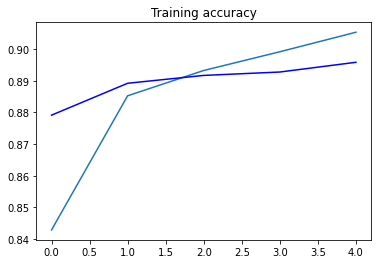

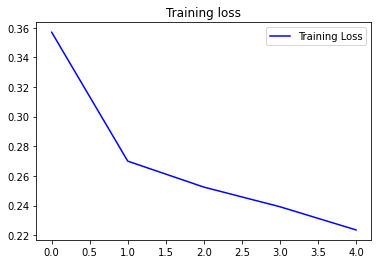

In [ ]:
import matplotlib.pyplot as plt

print(history)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc,val_acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()